# Tutorial: atomistic adversarial attacks

This tutorial introduces how adversarial attacks can be implemented in the context of atomistic simulation. Google Colab created by [Daniel Schwalbe-Koda](https://dskoda.com/), based on the [original tutorials](https://github.com/learningmatter-mit/Atomistic-Adversarial-Attacks) created with Aik Rui Tan.

Paper: D. Schwalbe-Koda, A. R. Tan, and R. Gomez-Bombarelli. Differentiable sampling of molecular geometries with uncertainty-based adversarial attacks. *Nat. Commun.* **12**, 5104 (2021). [Link](https://www.nature.com/articles/s41467-021-25342-8)

Interactive explanation: https://dskoda.com/final-project-atomistic-uncertainty/

# Adversarial attacks on 2D double well potential

In this notebook, we reproduce the example of adversarial attacks on the asymetric 2D double well shown in Fig. 2 of the [Atomistic Adversarial Attacks paper](https://doi.org/10.1038/s41467-021-25342-8).

The notebook uses the models and the helper functions in the `robust` folder of the [repo](https://github.com/dskoda/Atomistic-Adversarial-Attacks.git).

In [ ]:
!pip3 install git+https://github.com/dskoda/Atomistic-Adversarial-Attacks.git

  Cloning https://github.com/dskoda/Atomistic-Adversarial-Attacks.git to /tmp/pip-req-build-4yuv5jso
  Running command git clone --filter=blob:none --quiet https://github.com/dskoda/Atomistic-Adversarial-Attacks.git /tmp/pip-req-build-4yuv5jso
  Resolved https://github.com/dskoda/Atomistic-Adversarial-Attacks.git to commit 441aea4c866e253ab5e895fd8157dcd9159b7503
  Preparing metadata (setup.py) ... done
  Created wheel for AtomAttacks: filename=AtomAttacks-1.0-py3-none-any.whl size=24022 sha256=523e6d1662acf15e64891a2282da1cdebdc20531eb4c60e7f73f4622ae969ff3
  Stored in directory: /tmp/pip-ephem-wheel-cache-rr1f9g4q/wheels/7f/c7/6c/913ab9efef8770f95d73c9aaa98bd3277243300a288d597450
Successfully built AtomAttacks


In [ ]:
import robust as rb
from robust.pipeline import ForwardPipeline
from robust.loop import ActiveLearning
import torch
import numpy as np

from scipy import stats

from matplotlib import cm
import matplotlib.pyplot as plt

## Creating the 2D double well

Using the potentials available at the `robust` module, we created an asymetric 1D double well with the desired zeros, depth and offset. In particular, the equation for the potential is the following:

$$E(x, y) = 10 x^4 - 10 x^2 + 2x + 4 y^2$$

Then, the `potential` object creates the training set, the `true_potential` is used for the evaluation (e.g. the surrogate model, or analogous to a FF or DFT calculation). We also select the plotting range for the potentials, in order to achieve a better visualization for this work.

In [ ]:
AX = 10
BX = 1
CX = 2
AY = 4
BY = 0
CY = 0

ENERGY_THRESHOLD = -2

potential = rb.potentials.Masked2DDoubleWell(
    ax=AX, bx=BX, cx=CX,
    ay=AY, by=BY, cy=CY,
    emax=ENERGY_THRESHOLD,
    energy_noise=0.0,
)

true_potential = rb.potentials.TwoDimensionalDoubleWell(
    ax=AX, bx=BX, cx=CX,
    ay=AY, by=BY, cy=CY,
)

In [ ]:
PLOT_RANGE = 1.2
STEPS = 300

x = np.linspace(-PLOT_RANGE, PLOT_RANGE, STEPS)
y = np.linspace(-PLOT_RANGE, PLOT_RANGE, STEPS)

SHAPE = (len(x), len(y))

X, Y = np.meshgrid(x, y)
XY = np.stack([X.reshape(-1), Y.reshape(-1)], axis=1)
XY = torch.tensor(XY).to(torch.float32)

dplot = rb.PotentialDataset(*true_potential(XY))

/usr/local/lib/python3.10/dist-packages/robust/data.py:76: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return ch.tensor(tensor).reshape(len(tensor), -1)
/usr/local/lib/python3.10/dist-packages/robust/data.py:77: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return ch.tensor(tensor)


In [ ]:
xytrain = (2 * torch.rand(500, 2) - 1) * PLOT_RANGE
dset = rb.PotentialDataset(*potential(xytrain))

Now we can just visualize the training set (white dots) and the toy potential

<ipython-input-6-28c33f898f7b>:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap("viridis")


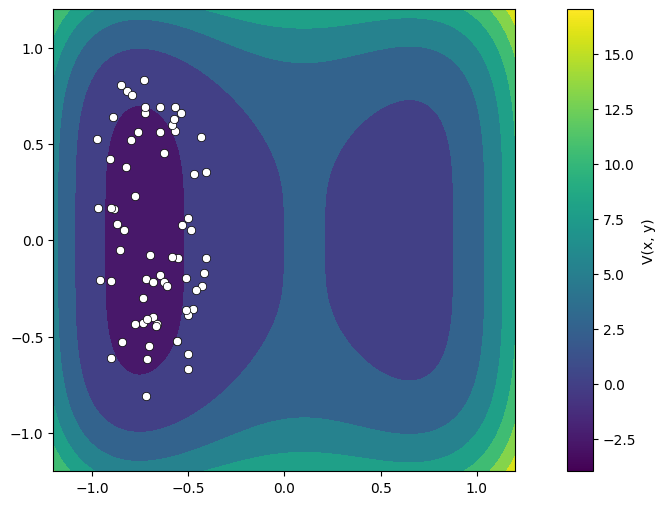

In [ ]:
Z = dplot.e.reshape(X.shape).numpy()

cmap = cm.get_cmap("viridis")
norm = cm.colors.Normalize(vmin=np.min(Z), vmax=np.max(Z))
scalarMap = cm.ScalarMappable(norm=norm, cmap=cmap)
c = scalarMap.to_rgba(Z)

fig, (ax, cax) = plt.subplots(1, 2, figsize=(7, 6), gridspec_kw={'width_ratios': (0.9, 0.05)})

ax.contourf(X, Y, Z, cmap=cmap)

xtrain, ytrain = dset.x[:, 0], dset.x[:, 1]
ax.scatter(xtrain, ytrain, c='w', linewidths=0.5, edgecolors='k')
ax.set_aspect('equal')

cbar = fig.colorbar(scalarMap, shrink=.65, cax=cax, orientation='vertical')
cbar.set_label('V(x, y)')

plt.show()

## Training the models

Now, we select all hyperparameters of the models. The NN ensemble is generated from the `model_params`. The `loss_params` are used both for the training and adversarial loss, although the latter uses only the temperature. `score_params` uses some deduplication strategies, as explained in Sec. II-C of the paper. Afterwards, the initial pipeline (i.e. one loop cycle) is created, and the model is trained.

In [ ]:
loss_params = {
    'energy_coef': 1,
    'forces_coef': 10,
    'temperature': 5,
}

model_params = {
    'input_dim': 2,
    'output_dim': 1,
    'num_layers': 4,
    'layer_dim': 1024,
    'num_networks': 5
}

optim_params = {
    'lr': 1e-3,
}

train_params = {
    'max_epochs': 500,
    'batch_size': 35,
}

attack_params = {
    'delta_std': 1e-2,
    'optim_kws': {'lr': 3e-3},
}

score_params = {
    'UncertaintyPercentile': {'percentile': 90},
}

prefix = 'models_2D'

DEVICE = "cuda"

In [ ]:
pipeline = ForwardPipeline(
    dset,
    model_params,
    loss_params,
    optim_params,
    train_params,
    attack_params,
    name=f'{prefix}/gen_1',
)

In [ ]:
loop = ActiveLearning(
    pipeline,
    true_potential,
    device=DEVICE,
    train_epochs=400,
    attack_epochs=500,
    scores=score_params,
    num_generations=4,
    name_prefix=prefix,
)

In [ ]:
loop.loop()

ACT_LEARN: GEN 1: training model
 Time | Epoch | Learning rate | Train loss | Validation loss | MAE Energy | MAE Forces | GPU Memory (MB)


/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at ../aten/src/ATen/cuda/CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


18:23 |    25 |     1.000e-03 |   211.9481 |        314.4604 |     5.1227 |    20.0136 |             122
18:28 |    50 |     1.000e-03 |   201.2297 |        294.4757 |     4.8554 |    19.7223 |             122
18:33 |    75 |     1.000e-03 |   150.8924 |        198.1474 |     4.8367 |    15.3959 |             122
18:38 |   100 |     1.000e-03 |    62.3181 |         93.0664 |    10.9168 |    11.4506 |             122
18:40 |   125 |     1.000e-03 |    34.4674 |         54.1257 |     1.6631 |     8.7399 |             122
18:41 |   150 |     1.000e-03 |    38.7864 |         73.7730 |     2.0716 |    10.2314 |             122
18:42 |   175 |     1.000e-03 |    30.2806 |         40.6720 |     2.3172 |     8.0230 |             122
18:44 |   200 |     1.000e-03 |    26.7138 |         35.6508 |     1.5441 |     7.1100 |             122
18:45 |   225 |     1.000e-03 |    20.9653 |         31.4730 |     1.4577 |     7.0049 |             122
18:47 |   250 |     1.000e-03 |    23.1940 |         28

/usr/local/lib/python3.10/dist-packages/robust/data.py:76: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return ch.tensor(tensor).reshape(len(tensor), -1)
/usr/local/lib/python3.10/dist-packages/robust/data.py:77: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return ch.tensor(tensor)


ACT_LEARN: GEN 1: evaluating attack
ACT_LEARN: GEN 2: training model
 Time | Epoch | Learning rate | Train loss | Validation loss | MAE Energy | MAE Forces | GPU Memory (MB)
19:10 |    25 |     1.000e-03 |    94.9756 |        179.4118 |    17.2951 |    16.0978 |             227
19:14 |    50 |     1.000e-03 |    88.5354 |        137.1593 |     8.4615 |    14.6391 |             227
19:16 |    75 |     1.000e-03 |    85.5484 |        136.1919 |     5.0898 |    14.4041 |             227
19:17 |   100 |     1.000e-03 |    85.3854 |        132.2772 |     4.1351 |    13.9649 |             227
19:19 |   125 |     1.000e-03 |    82.8073 |        135.8188 |     3.4002 |    14.0495 |             227
19:21 |   150 |     1.000e-03 |    76.8673 |        119.4844 |     3.6819 |    12.9628 |             227
19:24 |   175 |     1.000e-03 |    55.2073 |         94.2905 |     3.7812 |    10.8322 |             227
19:26 |   200 |     1.000e-03 |    10.3651 |         23.9514 |     2.3357 |     5.9098 |   

## Plotting the evolution of the active learning loop

This plot reproduces Fig. 2a of the paper, up to differences due to random initialization. It essentially shows all adversarial attacks and the evolution of the uncertainty/loss across generations.

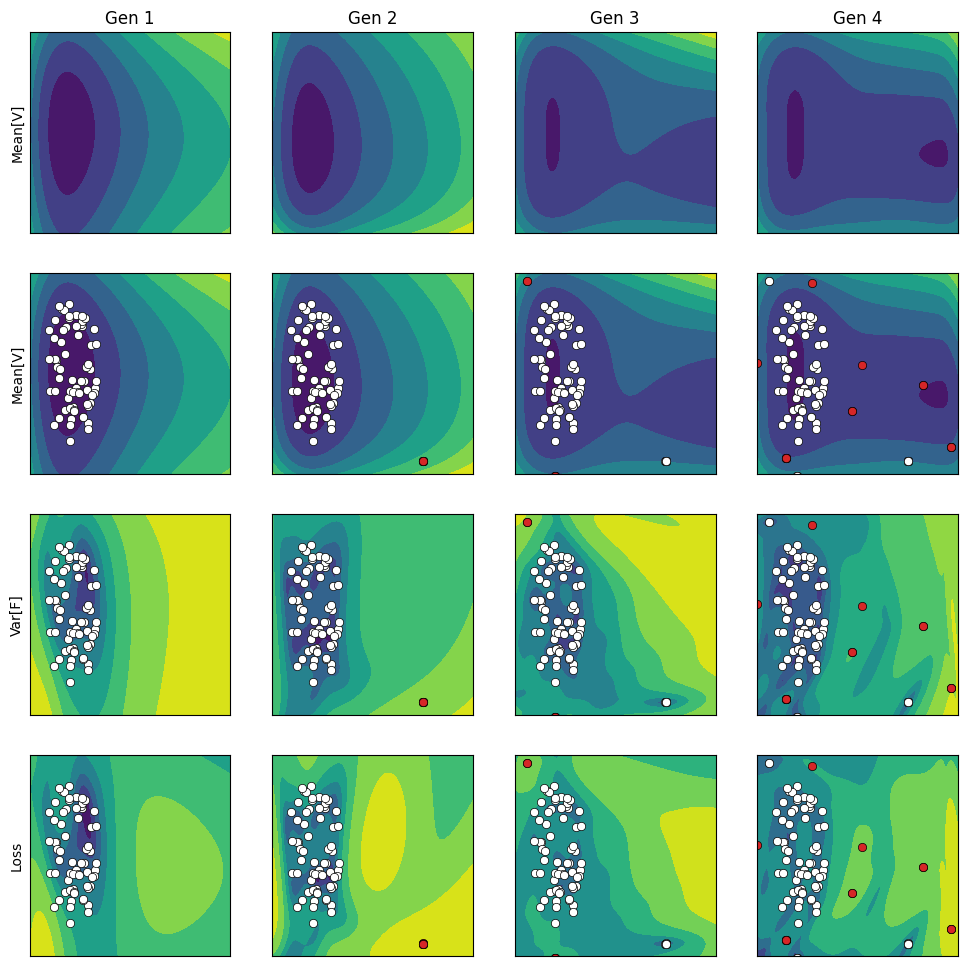

In [ ]:
generations = loop.generations
N_GENS = len(generations)
N_PLOTS = 4
LIMS = np.array([-PLOT_RANGE, PLOT_RANGE])

fig, ax_fig = plt.subplots(N_PLOTS, N_GENS, figsize=(N_GENS * 3, N_PLOTS * 3), sharex=True, sharey=True)

for gen, ax_row in zip(generations, ax_fig.T):
    pipeline = gen['pipeline']
    attacks = gen['attacks']
    attacks_truth = rb.PotentialDataset(*true_potential(attacks.x))

    dplot_model, _, _ = pipeline.evaluate(dplot.get_loader(train_params['batch_size']), DEVICE)

    ax = ax_row[0]
    # Predicted V contourf
    ax.contourf(
        dplot_model.x[:, 0].reshape(SHAPE),
        dplot_model.x[:, 1].reshape(SHAPE),
        dplot_model.e.mean(-1).reshape(SHAPE),
        zorder=-1
    )
    ax.set_aspect('equal')
    ax.set_xlim(LIMS)
    ax.set_ylim(LIMS)

    ax = ax_row[1]
    # Predicted V contourf
    ax.contourf(
        dplot_model.x[:, 0].reshape(SHAPE),
        dplot_model.x[:, 1].reshape(SHAPE),
        dplot_model.e.mean(-1).reshape(SHAPE),
        zorder=-1
    )
    ax.scatter(
        pipeline.dset.x[:, 0],
        pipeline.dset.x[:, 1],
        c='w',
        linewidths=0.5,
        edgecolors='k',
        label='training data',
    )

    if len(pipeline.dset_train) > 1:
        ax.scatter(
            pipeline.dset_train.x[:, 0],
            pipeline.dset_train.x[:, 1],
            c='w',
            linewidths=0.5,
            edgecolors='k',
            label='training data',
        )

    if len(attacks) > 0:
        ax.scatter(
            attacks_truth.x[:, 0],
            attacks_truth.x[:, 1],
            c='#d62627',
            linewidths=0.5,
            edgecolors='k',
            label='attacks',
        )

    ax.set_aspect('equal')

    ax.set_xlim(LIMS)
    ax.set_ylim(LIMS)

    ax = ax_row[2]
    # Var[F] countourf
    ax.contourf(
        dplot_model.x[:, 0].reshape(SHAPE),
        dplot_model.x[:, 1].reshape(SHAPE),
        torch.log(dplot_model.f.var(-1).sum(-1)).reshape(SHAPE),
        zorder=-1
    )
    ax.scatter(
        pipeline.dset.x[:, 0],
        pipeline.dset.x[:, 1],
        c='w',
        linewidths=0.5,
        edgecolors='k',
        label='training data',
    )

    if len(pipeline.dset_train) > 1:
        ax.scatter(
            pipeline.dset_train.x[:, 0],
            pipeline.dset_train.x[:, 1],
            c='w',
            linewidths=0.5,
            edgecolors='k',
            label='training data',
        )

    if len(attacks) > 0:
        ax.scatter(
            attacks_truth.x[:, 0],
            attacks_truth.x[:, 1],
            c='#d62627',
            linewidths=0.5,
            edgecolors='k',
            label='attacks',
        )

    ax.set_aspect('equal')

    ax.set_xlim(LIMS)
    ax.set_ylim(LIMS)

    ax = ax_row[3]
    adv_loss = pipeline.get_adv_loss()
    loss = -adv_loss.loss_fn(dplot_model.x, dplot_model.e, dplot_model.f).sum(-1)

    # loss countourf
    ax.contourf(
        dplot_model.x[:, 0].reshape(SHAPE),
        dplot_model.x[:, 1].reshape(SHAPE),
        torch.log(loss).reshape(SHAPE),
        zorder=-1
    )
    ax.scatter(
        pipeline.dset.x[:, 0],
        pipeline.dset.x[:, 1],
        c='w',
        linewidths=0.5,
        edgecolors='k',
        label='training data',
    )

    if len(pipeline.dset_train) > 1:
        ax.scatter(
            pipeline.dset_train.x[:, 0],
            pipeline.dset_train.x[:, 1],
            c='w',
            linewidths=0.5,
            edgecolors='k',
            label='training data',
        )

    if len(attacks) > 0:
        ax.scatter(
            attacks_truth.x[:, 0],
            attacks_truth.x[:, 1],
            c='#d62627',
            linewidths=0.5,
            edgecolors='k',
            label='attacks',
        )

    ax.set_aspect('equal')

    ax.set_xlim(LIMS)
    ax.set_ylim(LIMS)

ax_fig[0, 0].set_ylabel('Mean[V]')
ax_fig[1, 0].set_ylabel('Mean[V]')
ax_fig[2, 0].set_ylabel('Var[F]')
ax_fig[3, 0].set_ylabel('Loss')

for ax, gen in zip(ax_fig[0, :].reshape(-1), generations):
    ax.set_title(f"Gen {gen['generation']}")

for ax in ax_fig.reshape(-1):
    ax.spines['right'].set_visible(True)
    ax.spines['top'].set_visible(True)
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()

# Adversarial attacks on molecular systems

Now, instead of analyzing how adversarial attacks work on toy examples with the helper functions from `robust`, we can try to implement them from scratch on a real NN potential. We will use TorchANI models and data in this tutorial, but the principles can be easily translated to other NN potentials.

## Setting up TorchANI

In [ ]:
! pip install ase
! pip install torchani
! pip install py3Dmol
! wget https://www.dropbox.com/sh/2c8zdqc1hrqsgwy/AAD6l24ngoiFa6DRapF6HPk5a/ -O download.zip
! unzip download.zip -d download || [[ $? == 2 ]]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 27.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.5/103.5 kB 11.2 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylin

In [ ]:
!pip install py3Dmol
from google.colab import output
output.enable_custom_widget_manager()

In [ ]:
import ase
import tqdm
import random
import torch
import torchani

from ase.io import write
import py3Dmol
import numpy as np
import pandas as pd
import robust as rb
import matplotlib.pyplot as plt

/usr/local/lib/python3.10/dist-packages/torchani/aev.py:16: UserWarning: cuaev not installed
  warnings.warn("cuaev not installed")


## Loading the ANI-1x data and models

To save time in this tutorial, we limit ourselves to the ammonia molecule and pre-trained models. However, any other molecular system should be possible.

In [ ]:
# load the data and shift the energies
species_order = ['H', 'C', 'N', 'O']
species_mapper = {i: sp for i, sp in enumerate(species_order)}

energy_shifter = torchani.utils.EnergyShifter(None)

dspath = 'download/dataset/ani1-up_to_gdb4/ani_gdb_s01.h5'
data = torchani.data.load(dspath)
dset = list(data.species_to_indices())

# filtering the dataset to use only the ammonia molecule
dset = [
    x for x in dset
    if tuple(x["species"]) == (2, 0, 0, 0)
]

# load the ensemble of ANI-1x models
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
models = torchani.models.ANI1x(periodic_table_index=False).to(device)

/usr/local/lib/python3.10/dist-packages/torchani/resources/


In [ ]:
dset[:5]

[{'species': array([2, 0, 0, 0]),
  'coordinates': array([[ 0.01984805,  0.00597111, -0.0775079 ],
         [ 0.38537353, -0.88188523,  0.06741773],
         [ 0.31817394,  0.9305597 ,  0.03769168],
         [-0.9793074 , -0.13161534,  0.1687614 ]], dtype=float32),
  'energies': -56.5097683346},
 {'species': array([2, 0, 0, 0]),
  'coordinates': array([[ 0.00293417, -0.01456583, -0.14271113],
         [ 0.53284335, -0.7359605 ,  0.3407908 ],
         [ 0.22926642,  0.8202309 ,  0.438699  ],
         [-0.8028624 ,  0.11813609,  0.40033773]], dtype=float32),
  'energies': -56.5022091167},
 {'species': array([2, 0, 0, 0]),
  'coordinates': array([[-0.00749553,  0.01035514, -0.0950221 ],
         [ 0.56621414, -0.90169096,  0.22133695],
         [ 0.5284833 ,  0.9381108 ,  0.14924589],
         [-0.9905362 , -0.18027404,  0.14663656]], dtype=float32),
  'energies': -56.5066242896},
 {'species': array([2, 0, 0, 0]),
  'coordinates': array([[ 0.00870029,  0.00610197, -0.13030022],
         [

In [ ]:
len(models)

8

## Setting up adversarial attacks for ANI-1x models

Now, instead of using the pre-made pipeline for adversarial examples, we will demonstrate how to perform adversarial attacks from scratch for the ANI-1x models. The implementation should be very similar to any other model or architecture.

First, we create a class implementing the adversarial loss (also available at [the GitHub repo](https://github.com/dskoda/Atomistic-Adversarial-Attacks/blob/main/robust/loss.py)), as well as a function to compute the forces from the energy.

In [ ]:
class AdvLoss:
    def __init__(
        self,
        energies: list,
        temperature: float = 1,
        **kwargs
    ):
        self.e = torch.tensor(energies)
        self.temperature = temperature

    def boltzmann_probability(self, e):
        return torch.exp(-e / self.temperature)

    @property
    def partition_fn(self):
        """The 'partition function' is normalized to prevent
            problems with the gradients"""
        return self.boltzmann_probability(self.e).mean()

    def probability_fn(self, pred_energies: torch.tensor):
        return self.boltzmann_probability(pred_energies) / self.partition_fn

    def loss_fn(self, e: torch.tensor, f: torch.tensor):
        return -f.var(-1).mean(-1, keepdims=True) * self.probability_fn(e.mean(-1).reshape(-1, 1))

    def __call__(self, e: torch.tensor, f: torch.tensor):
        return self.loss_fn(e, f).sum()

def forces_from_energies(energies, coordinates):
    """Computes the energies by autodifferentiating the energies with respect to the input coordinates.
    The `retain_graph=True` is important to later compute the gradient of forces variance with respect
    to displacement `delta`.
    """
    return -torch.autograd.grad(
        torchani.units.hartree2kcalmol(energies),
        coordinates,
        allow_unused=True,
        retain_graph=True
    )[0]

def atoms_from_batch(species, coordinates):
    return ase.Atoms(
        symbols=[species_mapper[x] for x in species.squeeze().cpu().detach().numpy()],
        positions=coordinates.squeeze().cpu().detach().numpy(),
    )

In [ ]:
lr = 1e-2
kT = 1.0
n_epochs = 60
n_attacks = 1
batch_size = 1

# setting up the adversarial loss requires the energies of the training set
energies = np.array([
    torchani.units.hartree2kcalmol(d['energies'])
    for d in dset
])

# removing the minimum helps with the numerical stability of the "partition function"
loss_fn = AdvLoss(energies - energies.min(), kT)

# randomly sampling the input dataset
# seed_data = random.sample(dset, n_attacks)

# using the lowest energy geometry as dataset
seed_data = [dset[np.argmin([d["energies"] for d in dset])]]

loader = torchani.data.TransformableIterable(seed_data).collate(batch_size)

## Performing the adversarial attack for ammonia in ANI-1x

To implement the adversarial attack from scratch, we create a loop that maximizes the uncertainty while balancing reasonable energies.

In [ ]:
for i, batch in enumerate(loader):
    species = batch['species'].to(device)
    _coordinates = batch['coordinates'].to(device)

    # This step is important: it allows us to backpropagate the loss
    # with respect to the atomic coordinates
    _coordinates.requires_grad = True

    # delta is the displacement we are going to apply to the input coordinates
    # in order to increase the adversarial loss. We could initialize it with
    # zeros, but adding some input noise is helpful to prevent it from being
    # trapped.
    delta = 0.001 * torch.randn_like(_coordinates, device=device)
    delta.requires_grad = True
    optimizer = torch.optim.Adam([delta], lr=lr)

    trajectory = []

    # Performs the adversarial attack for n_epochs
    for epoch in tqdm.tqdm(range(1, n_epochs + 1)):
        optimizer.zero_grad()

        # displace the input coordinates
        coordinates = _coordinates + delta

        results = [m((species, coordinates)) for m in models]

        pred_energies = torch.stack([
            torchani.units.hartree2kcalmol(r.energies) - energies.min()
            for r in results
        ], dim=1)

        pred_forces = torch.stack([
            forces_from_energies(r.energies, coordinates)
             for r in results
        ], dim=1).squeeze()

        loss = -loss_fn(e=pred_energies, f=pred_forces)

        loss.backward()
        optimizer.step()

        fnorm = (pred_forces.squeeze() ** 2).sum(-1) ** 0.5
        fstd = fnorm.std(0).detach().cpu().numpy()

        trajectory.append({
            "atoms": atoms_from_batch(species, coordinates),
            "energy": pred_energies.mean(-1).item(),
            "forces_std_mean": fstd.mean(),
            "forces_std_max": fstd.max(),
        })

100%|██████████| 60/60 [00:08<00:00,  6.71it/s]


## Analyzing the results of the adversarial attack

Now that we performed the adversarial attack for one molecule, we can analyze its trajectory and statistics. To do that, we can plot the variation of energy and forces during the adversarial attack:

In [ ]:
df = pd.DataFrame(trajectory)

<ipython-input-25-59b208a9ad36>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  tax.set_yticklabels(tax.get_yticklabels(), color="r")


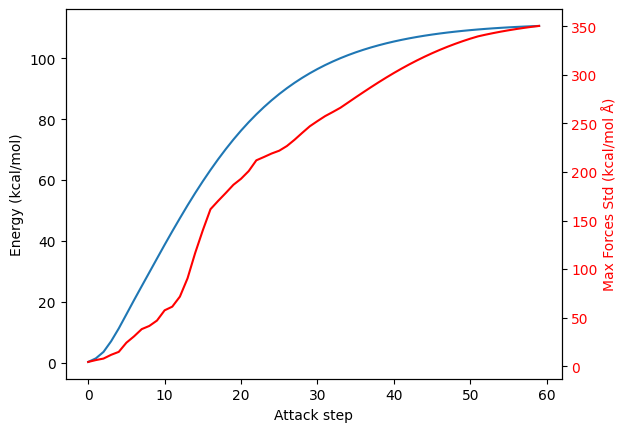

In [ ]:
fig, ax = plt.subplots()

ax.plot(df["energy"])
ax.set_ylabel("Energy (kcal/mol)")
ax.set_xlabel("Attack step")

tax = ax.twinx()
tax.plot(df["forces_std_max"], 'r')
tax.set_ylabel("Max Forces Std (kcal/mol Å)", color='r')
tax.set_yticklabels(tax.get_yticklabels(), color="r")

plt.show()

In [ ]:
atoms_traj = [step["atoms"] for step in trajectory[::2]]
write("trajectory.xyz", atoms_traj)

In [ ]:
viewer = py3Dmol.view(width=500, height=400)

viewer.addModelsAsFrames(open("trajectory.xyz", "r").read(), "xyz")
viewer.setStyle({"stick":{}})
viewer.zoomTo()
# viewer.animate({'loop': "backAndForth", 'reps': 100, 'interval': 30})
viewer.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.